# Семинар 2. Генеративные модели на основе динамики Ланжевена, оценка score-функций и метод NCSN

$\textbf{Преподаватель}:$ Колесов Александр


In [ ]:
import torch
from torch.distributions import MultivariateNormal, Normal
import numpy as np
import tqdm
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
torch.cuda.is_available()
DEVICE = 'cuda'

$\textbf{Основная идея данного ноутбука}$ состоит в том, что мы хотим научиться оценивать для любого произвольного распределения $p(x)$ по его выборке $x_{1},...,x_{n} \sim p(x)$ соответствующий $\nabla_{x}\log p(x)$, называемый score-функцией.

На вопрос: "А зачем нам собственно учить $\nabla_{x}\log p(x)$?" ответ такой. Для запуска генерации диффузионных моделей, о которых мы будем говорить чуточку позже, необходимо по выборке из $p(x)$  уметь считать $\nabla_{x}\log p(x)$.

## Teachers — Ground-Truth data

$\textbf{Teacher}$ — это класс, описывающий некоторое распределение $p(x)$ , которое нам бы хотелось аппроксимировать нейросетевыми подходами. Другими словами, score-функцию как раз такого распределения $p(x)$ нам и хотелось бы аппроксимировать.

Такое распределение $p(x)$ мы называем $\textbf{Teacher}$, и как класс он имеет следующие методы:

- sample (семплирование данных из распределения);
- log_prob (вычисление логарифма вероятности).

Несомненно, чтобы посчитать истинный логарифм вероятности распределения, мы определяем распределение так, чтобы аналитически иметь возможность вычислять его градиент логарифма. Распределение ниже  будем использовать как Teacher  $p(x)$:

$$\mathbb{P}(x) = \frac{1}{5}\mathcal{N}((-5,-5),I) + \frac{4}{5}\mathcal{N}((5,5),I).$$

In [ ]:
class GMMDist(object):
    def __init__(self, dim):
        self.mix_probs = torch.tensor([0.8, 0.2])
        self.means = torch.stack([5 * torch.ones(dim), -torch.ones(dim) * 5], dim=0)
        self.sigma = 1
        self.std = torch.stack([torch.ones(dim) * self.sigma for i in range(len(self.mix_probs))], dim=0)

    def sample(self, n):
        """
        n - int
        """
        n = torch.Size([n])[0]
        mix_idx = torch.multinomial(self.mix_probs, n, replacement=True)
        means = self.means[mix_idx]
        stds = self.std[mix_idx]
        return torch.randn_like(means) * stds + means

    def log_prob(self, samples):
        """
        samples - torch.Size([B,N])
        """
        logps = []
        for i in range(len(self.mix_probs)):
            logps.append((-((samples - self.means[i]) ** 2).sum(dim=-1) / (2 * self.sigma ** 2) - 0.5 * np.log(
                2 * np.pi * self.sigma ** 2)) + self.mix_probs[i].log())
        logp = torch.logsumexp(torch.stack(logps, dim=0), dim=0)
        return logp

Теперь определив класс  $p(x)$, мы можем просемплировать из него данные и посмотреть визуально, как данное распределение устроено.

In [ ]:
def plot_teachers(teacher, num_samples):
    """
    num_samples - int

    """
    plt.figure(figsize=(4,4),dpi=150 )
    samples = teacher.sample(num_samples)
    plt.scatter(samples[:,0],samples[:,1],s=10,edgecolor='black')
    plt.grid()


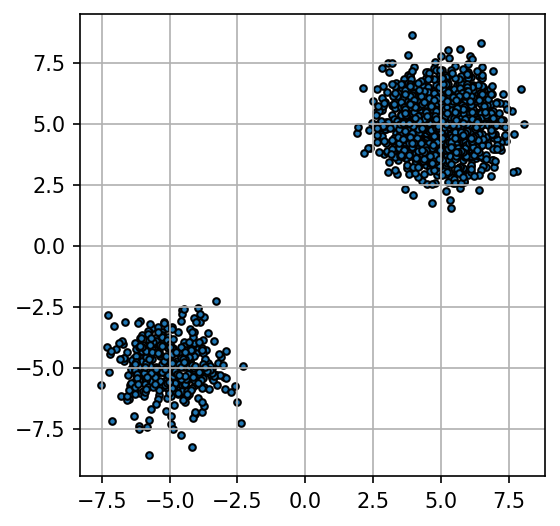

In [ ]:
DIM = 2
NUM_SAMPLES_PLOT = 2000
teacher =  GMMDist(DIM)
plot_teachers(teacher,  NUM_SAMPLES_PLOT)

Поскольку, как мы сказали, основная идея ноутбука состоит в том, чтобы оценить score-функцию нашего  $p(x)$, и так как мы знаем, как на самом деле выглядит  $p(x)$ (это гауссовсская смесь), мы можем вычислить его score-функцию аналитически.

In [ ]:
def data_score(x):
    x = x.detach()
    x.requires_grad_(True)
    y = teacher.log_prob(x).sum()
    return torch.autograd.grad(y, x)[0]

В качестве нейросетевого подхода для оценивания соответствующей score-функции  $p(x)$ выберем полносвязную линейную сеть, которую определим ниже.

In [ ]:
def toy_net(hiddens):
    model = []
    for inp,outp in zip(hiddens[:-1],hiddens[1:]):
        model.append(torch.nn.Linear(inp,outp,bias=True))
        model.append(torch.nn.ReLU())
    model.pop()
    return torch.nn.Sequential(*model)

## 1. Генеративное моделирование на основе score-функций

Чтобы оценить, насколько наша аппроксимация score-функции (хорошо построенная при помощи нейросетевого подхода) действительно приближает истинную score-функцию  $p(x)$, мы будем пользоваться визуальным сравнением этих score-функций, которые представляют собой некоторые векторные поля.

Поскольку score-функция — вектор-функция $\nabla_{x}\log p(x): \mathbb{R}^{D} \to \mathbb{R}^{D}$, изображение соответствующих векторных полей score-функций обеспечивается при помощи следующей функции:

In [ ]:
def plot_loss_quiever(model,teacher, label = None):

    grid_size = 20
    left_bound=-6
    right_bound=6
    mesh = []
    x = np.linspace(left_bound, right_bound, grid_size)
    y = np.linspace(left_bound, right_bound, grid_size)
    for i in x:
        for j in y:
            mesh.append(np.asarray([i, j]))

    mesh = np.stack(mesh, axis=0)
    mesh = torch.from_numpy(mesh).float()

    if label == "energy":
        mesh.requires_grad = True
        scores = model(mesh)
        scores = torch.autograd.grad(scores.sum(),mesh,create_graph=True)[0]
    else:
        scores = model(mesh.detach())


    mesh = mesh.detach().numpy()
    scores = scores.detach().numpy()
    fig,ax = plt.subplots(1,2,figsize=(16,8),sharex=True,sharey=True)

    ax[0].grid(False)
    ax[0].quiver(mesh[:, 0], mesh[:, 1], scores[:, 0], scores[:, 1], width=0.005)
    ax[0].set_title('Estimated scores', fontsize=16)
    ax[0].axis('square')

    scores = data_score(torch.from_numpy(mesh))
    scores = scores.detach().numpy()

    ax[1].grid(False)
    ax[1].quiver(mesh[:, 0], mesh[:, 1], scores[:, 0], scores[:, 1], width=0.005)
    ax[1].set_title('Data scores', fontsize=16)
    ax[1].axis('square')



```
# Выбран кодовый формат
```

### 1.1. Дивергенция Фишера

Напомним, что мы сами выбрали $p(x)$ по своему усмотрению. Следовательно, знаем истинное значение его score-функции, и самым простым способом оценить score-функцию  $p(x)$ будет **решение задачи регрессии**. При решении мы как будто предполагаем, что знаем $\nabla_{x}\log p(x)$, и наша нейронная сеть пытатется регрессировать на истинные значения score-функции. Такой подход и называется $\textbf{минимизацией дивергенции Фишера}$.

Дивергенция Фишера определяется следующим образом.

Пусть $p(x)$ и $q(x)$ — это истинное распределение и его аппроксимация соответственно. Важно, что обе функции скалярные. Тогда
$$ F(\mathbb{Q}||\mathbb{P})=\frac{1}{2}\int || - \nabla_{x}\log \mathbb{Q}(x) + \nabla_{x} \log \mathbb{P}(x) ||_{2}^{2}d\mathbb{P}(x).  $$

Теперь разберем подробнее, что представляет собой наша аппроксимация.

Наша нейронная сеть — это градиент логарифма ненормализованной плотности. И тут возникается важный вопрос: а почему ненормализованной? Сейчас разберемся и поймем, почему это упрощает нам жизнь.

$\textbf{Нотация}:$

- $x \in \mathbb{R}^{D}, \quad x \sim \mathbb{P}(\cdot).$
- Наша модель учит аппроксимацию $\nabla_{x}\log \mathbb{Q}(x,\theta)$ на $\nabla_{x}\log \mathbb{P}(x)$.
- То есть по сути наша модель учит распределение $\mathbb{Q}(x,\theta)$.
- Мы знаем, что вероятностное распределение устроено так, что $\int_{x} \mathbb{P}(x)dx = 1$.  Но выполняется ли то же самое для обучаемой нами  $\mathbb{Q}(x,\theta)$ или же она ненормализованная и тогда интеграл $\int_{x} \mathbb{Q}(x, \theta)dx = Z( \theta)$ равен некоторой константе?
- Нормализованную модель для аппроксимации $\mathbb{P}$ обозначим через $\mathbb{\hat{Q}}(x, \theta) = \frac{1}{Z(\theta)}\mathbb{Q}(x,\theta)$, тогда ненормализованная аппроксимация $\mathbb{Q}(x,\theta)$.
- $\mathbb{\hat{Q}}(x, \theta)$ называется Energy-based-моделью.

А теперь важно пояснить, почему нет разницы в использовании нормализованной или ненормализованной модели.

Рассмотрим градиент аппроксимации:

$$ \nabla_{x} \log \mathbb{\hat{Q}}(x,\theta) = \nabla_{x} \log \mathbb{Q}(x,\theta) - \nabla_{x} \log Z(\theta) = \nabla_{x} \log \mathbb{Q}(x,\theta) - 0. $$

Мы видим, что градиент логарифма нормализованной плотности совпадает с градиентом логарифма ненормализованной.

![ChessUrl](https://media3.giphy.com/media/JRPftUYuIRw3axuh5y/giphy.gif "chess")


In [ ]:
def fischer_divergence(net, data, teacher):

    """
    net - torch.nn.Module
    teacher    - object
    data      - torch.Size([B,N])
    """

    data.requires_grad = True
    logq = net(data) # torch.Size([B,1])
    logp = teacher.log_prob(data.cpu()).to(DEVICE)# torch.Size([B,1])
    q_score = torch.autograd.grad(logq.sum(), data,
                                   create_graph=True,retain_graph=True)[0]
    p_score = torch.autograd.grad(logp.sum(), data,
                                 create_graph=True,retain_graph=True)[0]
    return 0.5*torch.mean(torch.norm((-q_score + p_score)**2,dim=-1))

Определим некоторые гиперпараметры нашей нейросети и решим задачу регрессии.

In [ ]:
HIDDENS = [DIM,64,128,256,128,64,2]
model = toy_net(HIDDENS).to(DEVICE)
opt = torch.optim.Adam(model.parameters(),lr=1e-5)
batch_size=2048
iterations=5000
losses = []
for _ in tqdm.tqdm(range(iterations)):
    opt.zero_grad()
    samples = teacher.sample(batch_size).to(DEVICE)
    loss = fischer_divergence(model,samples,teacher)
    loss.backward()
    opt.step()
    losses.append(loss.item())

100%|██████████| 5000/5000 [00:34<00:00, 143.92it/s]


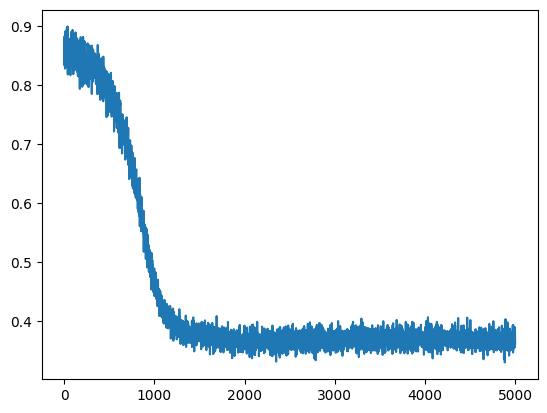

In [ ]:
plt.plot(losses);

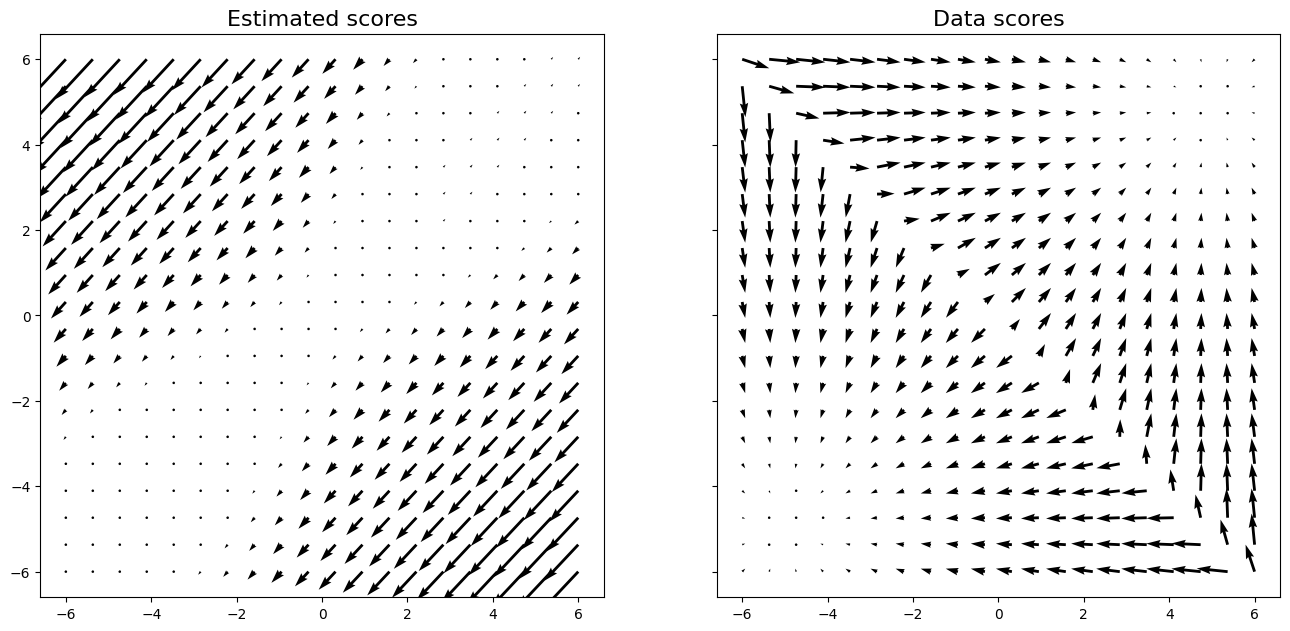

In [ ]:
plot_loss_quiever(model.cpu(), teacher)

Решая задачу регрессии,  мы не совсем конкретно определяем значения между модами для векторного поля. Позже мы объясним этот эффект. Но как вы думаете: почему сейчас так происходит?

### 1.2.  Матчинг  score-функций

К сожалению, зачастую мы не знаем, как на самом деле выглядит $p(x)$, а оценивать score-функцию этого распределения нам нужно. И тут на помощь приходит следующая теорема.

$\textbf{Теорема 1}.$
Пусть $\psi(x,\theta): \mathbb{R}^{D} \to \mathbb{R}^{D}$ — дифференцируемая функция, которая является нашей аппроксимацией для score-функции $\nabla_{x}\log p(x)$. Тогда каждая компонента нашей аппроксимации и ее соответствующая первая производная выглядят так:

$$\psi_{i}(x,\theta) = \frac{\partial \log q(x,\theta)}{\partial x_{i}}, \quad \frac{\partial \psi(x,\theta)}{\partial x_{i}} = \frac{\partial^{2} \log q(x,\theta)}{\partial x_{i}^{2}}. $$

Тогда минимизация дивергенции Фишера эквивалентна

$$ F(\mathbb{Q}||\mathbb{P}) ≈ \int_{\mathbb{R}^{D}} \sum_{i=1}^{D} \{ \frac{\partial \psi(x,\theta)}{\partial x_{i}}+ \frac{1}{2}||\psi(x,\theta)||_{2}^{2}\}d\mathbb{P}(x) + \text{Const}.$$

$\textbf{Польза теоремы 1}$

Давайте перепишем последнее выражение из теоремы в более наглядном виде через математическое ожидание:

$$ \mathbb{E}_{\mathbb{P}(x)}\left [ \frac{1}{2}|| \psi(x,\theta)||_{2}^{2} +
 \sum_{i=1}^{D}\frac{\partial \psi(x, \theta)}{\partial x_{i}}\right ] + \text{Const}.$$

Как мы видим, главная прелесть в том, что здесь не нужно знать аналитическое выражение для $\mathbb{P}(x)$, а нужны лишь семплы из $\mathbb{P}(x)$,  чтобы оценить математическое ожидание через оценивание интеграла Монте-Карло.

In [ ]:
def score_estimation(score_net, data):
    """
    energy_net - torch.nn.Module
    data       - torch.Size([B,N])
    """
    data.requires_grad = True
    score = score_net(data)#torch.Size([B,N])
    loss1 =  0.5*torch.norm(score,dim=-1)**2 # torch.Size([B])
    grad_score = torch.autograd.grad(score.sum(),data,
                                    create_graph=True,retain_graph=True)[0]
    loss2 = grad_score.sum(dim=-1)# torch.Size([B])
    return torch.mean(loss1 + loss2 ,dim = 0)

In [ ]:
HIDDENS = [DIM,64,128,256,128,64,2]
model = toy_net(HIDDENS).to(DEVICE)
opt = torch.optim.Adam(model.parameters(),lr=1e-5)
batch_size=2048
iterations=5000
losses = []
for _ in tqdm.tqdm(range(iterations)):
    opt.zero_grad()
    samples = teacher.sample(batch_size).to(DEVICE)
    loss =  score_estimation(model,samples)
    loss.backward()
    opt.step()
    losses.append(loss.item())

100%|██████████| 5000/5000 [00:19<00:00, 253.49it/s]


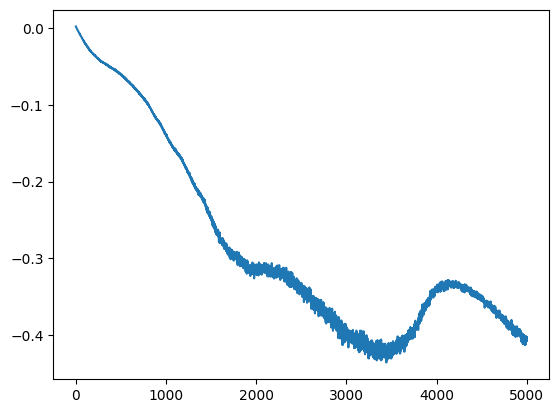

In [ ]:
plt.plot(losses);

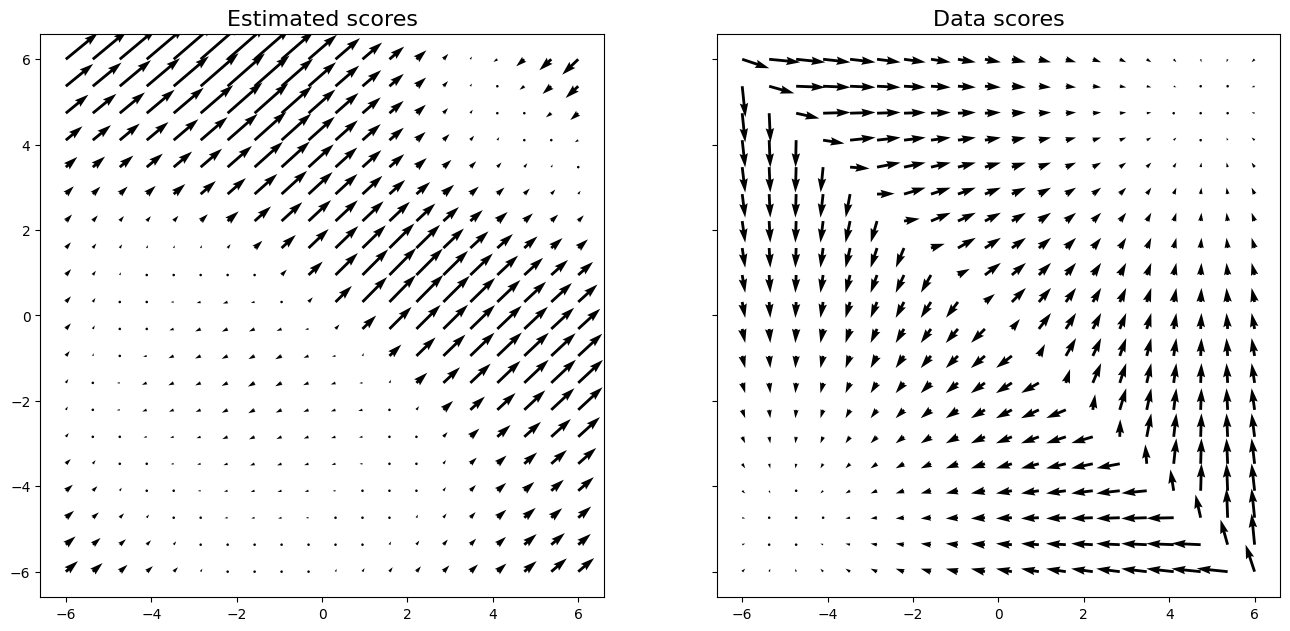

In [ ]:
plot_loss_quiever(model.cpu(),teacher)

Видим, что метод демонстрирует не самые хорошие результаты, и со сходимостью у него все плохо. Как думаете: с чем это может быть связано? (Подсказка: оптимизационная задача.)

### 1.3. Оценивание и матчинг score-функций с зашумлением

Теперь попробуем сделать один трюк: учить score-функцию не истинного $p(x)$ , а его же, но немного зашумленного, и посмотрим к чему это приведет.

Пусть $\mathbb{P}_{\sigma}$ — это зашумленное распределение $\mathbb{P}$.  Прежде всего мы выбираем уровень шума $\sigma$ вручную.

- $\mathbb{q}_{\sigma}(\tilde{x}|x) = \mathcal{N}(\tilde{x}|x,\sigma^{2}I)$ — условное распределение зашумления.
- $\mathbb{P}_{\sigma}(\tilde{x},x) =\mathbb{q}_{\sigma}(\tilde{x}|x)\mathbb{P}(x)$ — совместное распределение.
- $\mathbb{P}_{\sigma}(\tilde{x}) = \int \mathbb{P}_{\sigma}(\tilde{x},x) dx$ — маргинальное распределение.

$\textbf{Теорема 2.}$ Пусть $\mathbb{P}(x)$ — истинное распределение, в то время как $\psi(x,\theta): \mathbb{R}^{D} \to \mathbb{R}^{D}$ — обучаемая score-функция для градиента логарифма $\mathbb{P}$. Тогда при небольшом количестве введенного шума   $\sigma$ истинный  $\nabla_{x}\log \mathbb{P}$ не сильно отличается от зашумленного
 $\nabla_{x}\log \mathbb{P}_{\sigma}$ и для него верна следующая оценка:

$$ F(\mathbb{Q}||\mathbb{P}(x))  \approx F(\mathbb{Q}||\mathbb{P}_{\sigma}(x)) \approx \mathbb{E}_{\mathbb{P}_{\sigma}(x)} \left\{ \frac{1}{2}||\psi(x,\theta) - \frac{\partial}{\partial x} \log \mathbb{P}_{\sigma}(x) ||_{2}^{2} \right \} \sim \mathbb{E}_{\mathbb{P}_{\sigma}(x,\tilde{x})}\left\{\frac{1}{2}||\psi(\tilde{x},\theta) - \frac{\partial}{\partial \tilde{x}} \log \mathbb{q}_{\sigma}(\tilde{x}|x) ||_{2}^{2}\right\}.$$

$\textbf{Суть теоремы 2}$

Поскольку мы заметили, что результат теоремы 1 привносит нестабильную задачу оптимизации, нам хотелось бы исправить этот момент.  Поэтому мы вводим слегка зашумленное истинное распределение данных и пытаемся найти score-функцию.

И очень удачно эта задача сводится к регрессии score-функции на градиент логарифма условного нормального распределения, что привносит $\textbf{выпуклую задачу оптимизации}$ и дает отличные результаты на практике. Ровно для получения таких преимуществ нам и нужно ввести немного шума.

In [ ]:
def denoising_score_estimation( score_net, samples, sigma):

    """
    score_net - torch.nn.module
    samples   - torch.Size([B,N])
    sigma     - int
    """

    perturbed_samples = samples + torch.randn_like(samples, device = samples.device)*sigma
    score = score_net(perturbed_samples)
    dlogq =  1/sigma**2*(samples - perturbed_samples )
    return 0.5*torch.mean(torch.norm((score - dlogq)**2,dim=-1))

In [ ]:
model = toy_net(HIDDENS).to(DEVICE)
opt = torch.optim.Adam(model.parameters(),lr=1e-5)
batch_size=2048
iterations=5000
losses = []
for _ in tqdm.tqdm(range(iterations)):
    opt.zero_grad()
    samples = teacher.sample(batch_size).to(DEVICE)
    loss =  denoising_score_estimation(model,samples,0.01)
    loss.backward()
    opt.step()
    losses.append(loss.item())

100%|██████████| 5000/5000 [00:13<00:00, 370.54it/s]


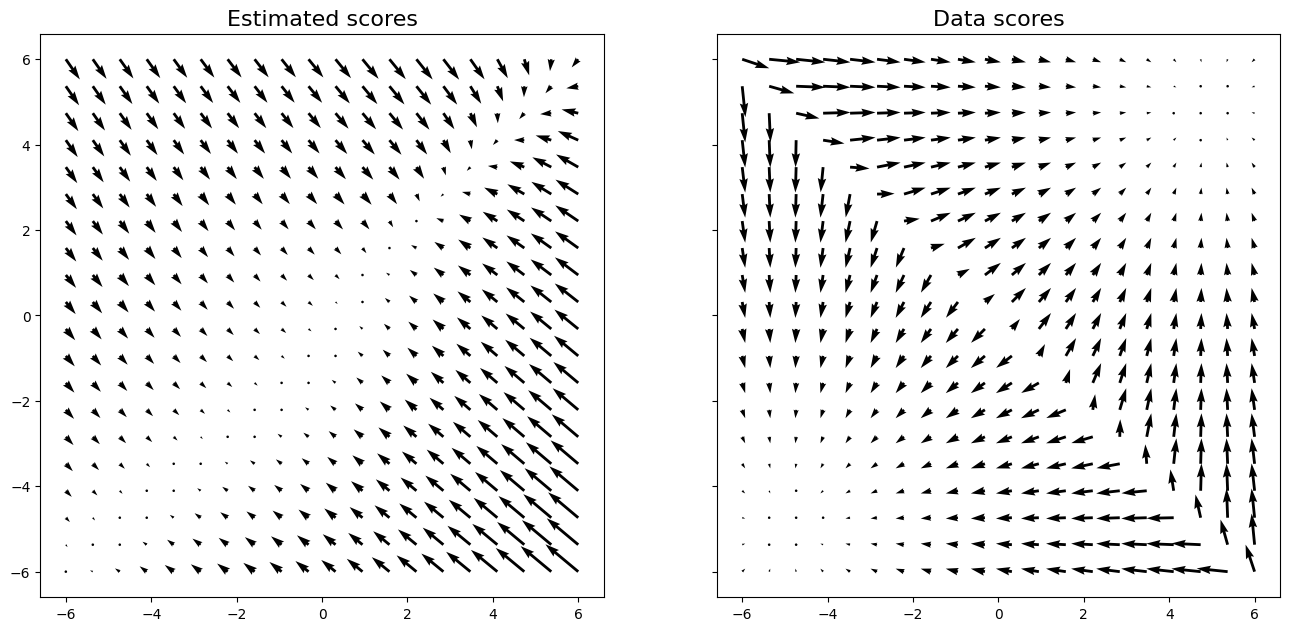

In [ ]:
plot_loss_quiever(model.cpu(),teacher)

Обучается гораздо лучше, в отличие от предыдущего метода,  и как раз за счет более простой оптимизационной задачи, которую мы поставили.

### Проблема score-оценивания

Какую общую проблему score-оценивания вы заметили, разбирая три предыдущих метода?

![Alt Text](  https://yang-song.net/assets/img/score/pitfalls.jpg)

## 2.  Шумо-обусловленные score-функции (NCSN) на простых датасетах

Когда вы натренируете  score-based-модель $\psi_{\theta}(x) = \nabla_{x} \log \mathbb{P}(x)$, можно использовать итеративную динамику  Ланжевена, чтобы получать семплы из распределения.

Динамика Ланжевена обеспечивает MCMC-процедуру, чтобы семплировать из распределения $\mathbb{P}(x)$,  используя только его score-функцию.  Это инициирует  цепочку из произвольного  априорного распределения $x_{0} \sim \pi(x)$ и затем итерирует цепочку по такому правилу:

$$x_{k+1} = x_{k} + \epsilon \nabla_{x} \log \mathbb{P}(x) + \sqrt{2\epsilon}z, \quad z \sim \mathcal{N}(z|0,I).$$

Если $\epsilon \to 0$  и $K \to \infty$ , то  $x_{k}$,  получаемые динамикой Ланжевена, сходятся к семплам из  $\mathbb{P}(x)$. На практике ошибка сходимости незначительна,  если $\epsilon$ достаточно маленькое и $K$  достаточно большое.

![Alt Text]( https://yang-song.net/assets/img/score/langevin.gif)

Затем мы оцениваем score-функцию каждого зашумленного распределения $\nabla \log \mathbb{P}{\sigma_{i}}(x)$ при помощи тренировки NCSN-модели $\psi(x_{i},\sigma_{i})$ с методологией score matching, такой что

$$\psi(x_{i},\sigma_{i}) = \nabla_{x} \log \mathbb{P}_{\sigma}(x_{i}).$$


![Alt Text](https://yang-song.net/assets/img/score/multi_scale.jpg)



Тренировочная функция потерь $\psi_{\theta}(x_{i},\sigma_{i})$ — это взвешенные дивергенции Фишера для каждого уровня шума. Мы используем такую функцию потерь для обучения:

$$ \sum_{i=1}^{L} \lambda(i) \mathbb{E}_{\mathbb{P}_{\sigma_{i}}}||\psi_{\theta}(x,\sigma_{i}) - \nabla_{x} \log \mathbb{P}_{\sigma_{i}}(x)||_{2}^{2}.$$

После тренировки нашей NCSN-модели $\psi_{\theta}(x,\sigma_{i})$ можно производить семплы из желаемого распределения. Для этого запускаем динамику Ланжевена для каждого уровня шума $i = L,L-1,...,1$. Такой метод называется annealed Langevin dynamics,  поскольку уровень шума $\sigma_{i}$ постепенно уменьшается (anneals) со временем.

 ![Alt Text]( https://yang-song.net/assets/img/score/ald.gif)



In [ ]:
def visualize(teacher, model, left_bound=-1., right_bound=1., savefig=None, step=None, device=None):

        #---------------------------------------------------#
        fig,ax = plt.subplots(2,3, figsize=(27,18),sharex=True, sharey=True,dpi=150 )

        mesh = []
        grid_size = 100
        x = np.linspace(left_bound, right_bound, grid_size)
        y = np.linspace(left_bound, right_bound, grid_size)
        for i in x:
            for j in y:
                mesh.append(np.asarray([i, j]))

        mesh = np.stack(mesh, axis=0)
        mesh = torch.from_numpy(mesh).float()
        if device is not None:
            mesh = mesh.to(device)

        logp_true = teacher.log_prob(mesh)
        logp_true = logp_true.view(grid_size, grid_size).exp()

        ax[0,0].grid(False)
        ax[0,0].axis('off')
        ax[0,0].set_title('Data density', fontsize=16)
        ax[0,0].imshow(np.flipud(logp_true.cpu().numpy()), cmap='inferno')



        #---------------------------------------------------------#

        grid_size = 20
        mesh = []
        x = np.linspace(left_bound, right_bound, grid_size)
        y = np.linspace(left_bound, right_bound, grid_size)
        for i in x:
            for j in y:
                mesh.append(np.asarray([i, j]))

        mesh = np.stack(mesh, axis=0)
        mesh = torch.from_numpy(mesh).float()
        if device is not None:
            mesh = mesh.to(device)


        scores = model(  mesh.detach().to(DEVICE) )
        mesh = mesh.detach().cpu().numpy()
        scores = scores.detach().cpu().numpy()

        ax[0,1].grid(False)
        ax[0,1].axis('off')
        ax[0,1].axis('square')
        ax[0,1].quiver(mesh[:, 0], mesh[:, 1], scores[:, 0], scores[:, 1], width=0.005)
        ax[0,1].set_title('Estimated scores', fontsize=16)



        #-------------------------------------------------------------#

        samples = teacher.sample(1280)
        samples = samples.detach().cpu().numpy()
        ax[0,2].scatter(samples[:, 0], samples[:, 1], s=0.5)
        ax[0,2].axis('square')
        ax[0,2].set_title('data samples',fontsize=16)
        ax[0,2].set_xlim([left_bound, right_bound])
        ax[0,2].set_ylim([left_bound, right_bound])


        #------------------------------------------------------------#


        samples_ = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound

        samples = ncsn.langevin_dynamics(model, samples_).detach().numpy()
        ax[1,0].scatter(samples[:, 0], samples[:, 1], s=0.5)
        ax[1,0].axis('square')
        ax[1,0].axis('square')
        ax[1,0].set_title('Model Langevin dynamics',fontsize=16)
        ax[1,0].set_xlim([left_bound, right_bound])
        ax[1,0].set_ylim([left_bound, right_bound])


        #-----------------------------------------------------------#


        scores = data_score(torch.from_numpy(mesh) )
        scores = scores.detach().numpy()

        ax[1,1].axis('off')
        ax[1,1].quiver(mesh[:, 0], mesh[:, 1], scores[:, 0], scores[:, 1], width=0.005)
        ax[1,1].set_title('True Data scores', fontsize=16)
        ax[1,1].axis('square')



        samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound

        samples = ncsn.langevin_dynamics(data_score, samples).detach().numpy()
        ax[1,2].scatter(samples[:, 0], samples[:, 1], s=0.1)
        ax[1,2].axis('square')
        ax[1,2].set_title('True Langevin dynamics data',fontsize=16)
        ax[1,2].set_xlim([left_bound, right_bound])
        ax[1,2].set_ylim([left_bound, right_bound])


        """
        samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
        sigmas = torch.exp(torch.linspace(np.log(20), 0., 10)).to(DEVICE)
        labels = torch.linspace(1,10,10).to(DEVICE)
        samples = ncsn.anneal_langevin_dynamics(ncsn.score, samples.to(DEVICE), sigmas
                                             , labels).detach().cpu().numpy()

        plt.scatter(samples[:, 0], samples[:, 1], s=0.2)
        plt.axis('square')
        plt.title('Right Annealed Langevin dynamics samples')
        plt.xlim([left_bound, right_bound])
        plt.ylim([left_bound, right_bound])
        plt.show()
        """
        fig.tight_layout()
        plt.show()

In [ ]:
class NCSN(torch.nn.Module):

    def __init__(self, score, teacher, train_steps, lr, batch_size):
        super().__init__()
        self.train_steps = train_steps
        self.score = score
        self.teacher = teacher
        self.lr = lr
        self.batch_size = batch_size

    def langevin_dynamics(self, score, init, lr=0.1, step=1000):

        """
        score - torch.nn.Module
        init  - torch.Size([B,N])
        """
        for step in range(step):
            init = init + score(init)*lr + torch.randn_like(init,device=init.device)*np.sqrt(2*lr)
        return init

    def anneal_langevin_dynamics(self, score, init, sigmas, lr=0.1, n_steps_each=100):

        """
        score   - space-time torch.nn.Module
        init    - torch.Size([B,N])
        sigmas  - List
        """
        #with torch.no_grad
        for sigma in sigmas:
            current_lr = lr*sigma**2/sigmas[-1]**2
            for step in range(n_steps_each):
                init = init + 0.5*current_lr*score(init, sigma).detach()
                init = init + torch.randn_like(init, device=init.device)*np.sqrt(current_lr)

        return init

    def anneal_dsm_score_estimation(self,scorenet, samples, labels, sigmas, anneal_power=2.):

        batch_size = samples.shape[0]
        samples = samples.repeat(len(sigmas),1).reshape(len(sigmas),-1,samples.shape[-1])
        perturbed_samples = samples + torch.randn_like(samples)*sigmas.reshape(-1,1,1)

        scores = scorenet( perturbed_samples.reshape(-1,samples.shape[-1]),
                           labels.view(-1,1).expand( len(sigmas), batch_size).flatten().view(-1) )

        target = -1.*(perturbed_samples.reshape(-1,samples.shape[-1]) - samples.reshape(-1, samples.shape[-1]) )*\
                 (sigmas.view(-1,1).expand(len(sigmas),  batch_size).flatten().view(-1,1))**2

        loss = 1/2.*((scores - target)**2).sum(dim = -1)

        loss =  loss*\
              (sigmas.view(-1,1).expand(len(sigmas), batch_size).flatten().view(-1) )

        return loss.mean(dim=0)

    def train_(self, iterations = 10000, batch_size = 128):

        """
        hidden_units = 128
        score = torch.nn.Sequential(
            torch.nn.Linear(3, hidden_units),
            torch.nn.Softplus(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.Softplus(),
            torch.nn.Linear(hidden_units, 2),
        )
        """
        losses = []
        optimizer = torch.optim.Adam(self.score.parameters(), lr=0.001)
        teacher = GMMDist(dim=2)

        for step in  tqdm(range(iterations)):
            samples = teacher.sample((batch_size,)).to(DEVICE)

            #loss, *_ = sliced_score_estimation_vr(score, samples, n_particles=1)

            loss = self.anneal_dsm_score_estimation(self.score, samples, labels = torch.linspace(1,10,10).to(DEVICE) ,
                                                    sigmas=torch.exp(torch.linspace(np.log(20), 0., 10)).to(DEVICE))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        return self.score, teacher, losses

    def train(self):
        opt_score = torch.optim.Adam(self.score.parameters(),lr=self.lr)
        for step in tqdm.tqdm(range(self.train_steps)):
            samples = self.teacher.sample(self.batch_size)
            opt_score.zero_grad()
            loss,*_ = sliced_score_estimation_vr(self.score, samples, n_particles = 1)
            loss.backward()
            opt_score.step()
        visualize(self.teacher, self.score, -8, 8)

In [ ]:
hidden_units = 128
model = torch.nn.Sequential(
    torch.nn.Linear(2, hidden_units),
    torch.nn.Softplus(),
    torch.nn.Linear(hidden_units, hidden_units),
    torch.nn.Softplus(),
    torch.nn.Linear(hidden_units, 2),
)
ncsn = NCSN(model, teachers[0], train_steps = 1000,lr=1e-3,batch_size=128)

In [ ]:
DEVICE="cpu"

100%|██████████| 1000/1000 [00:02<00:00, 482.13it/s]


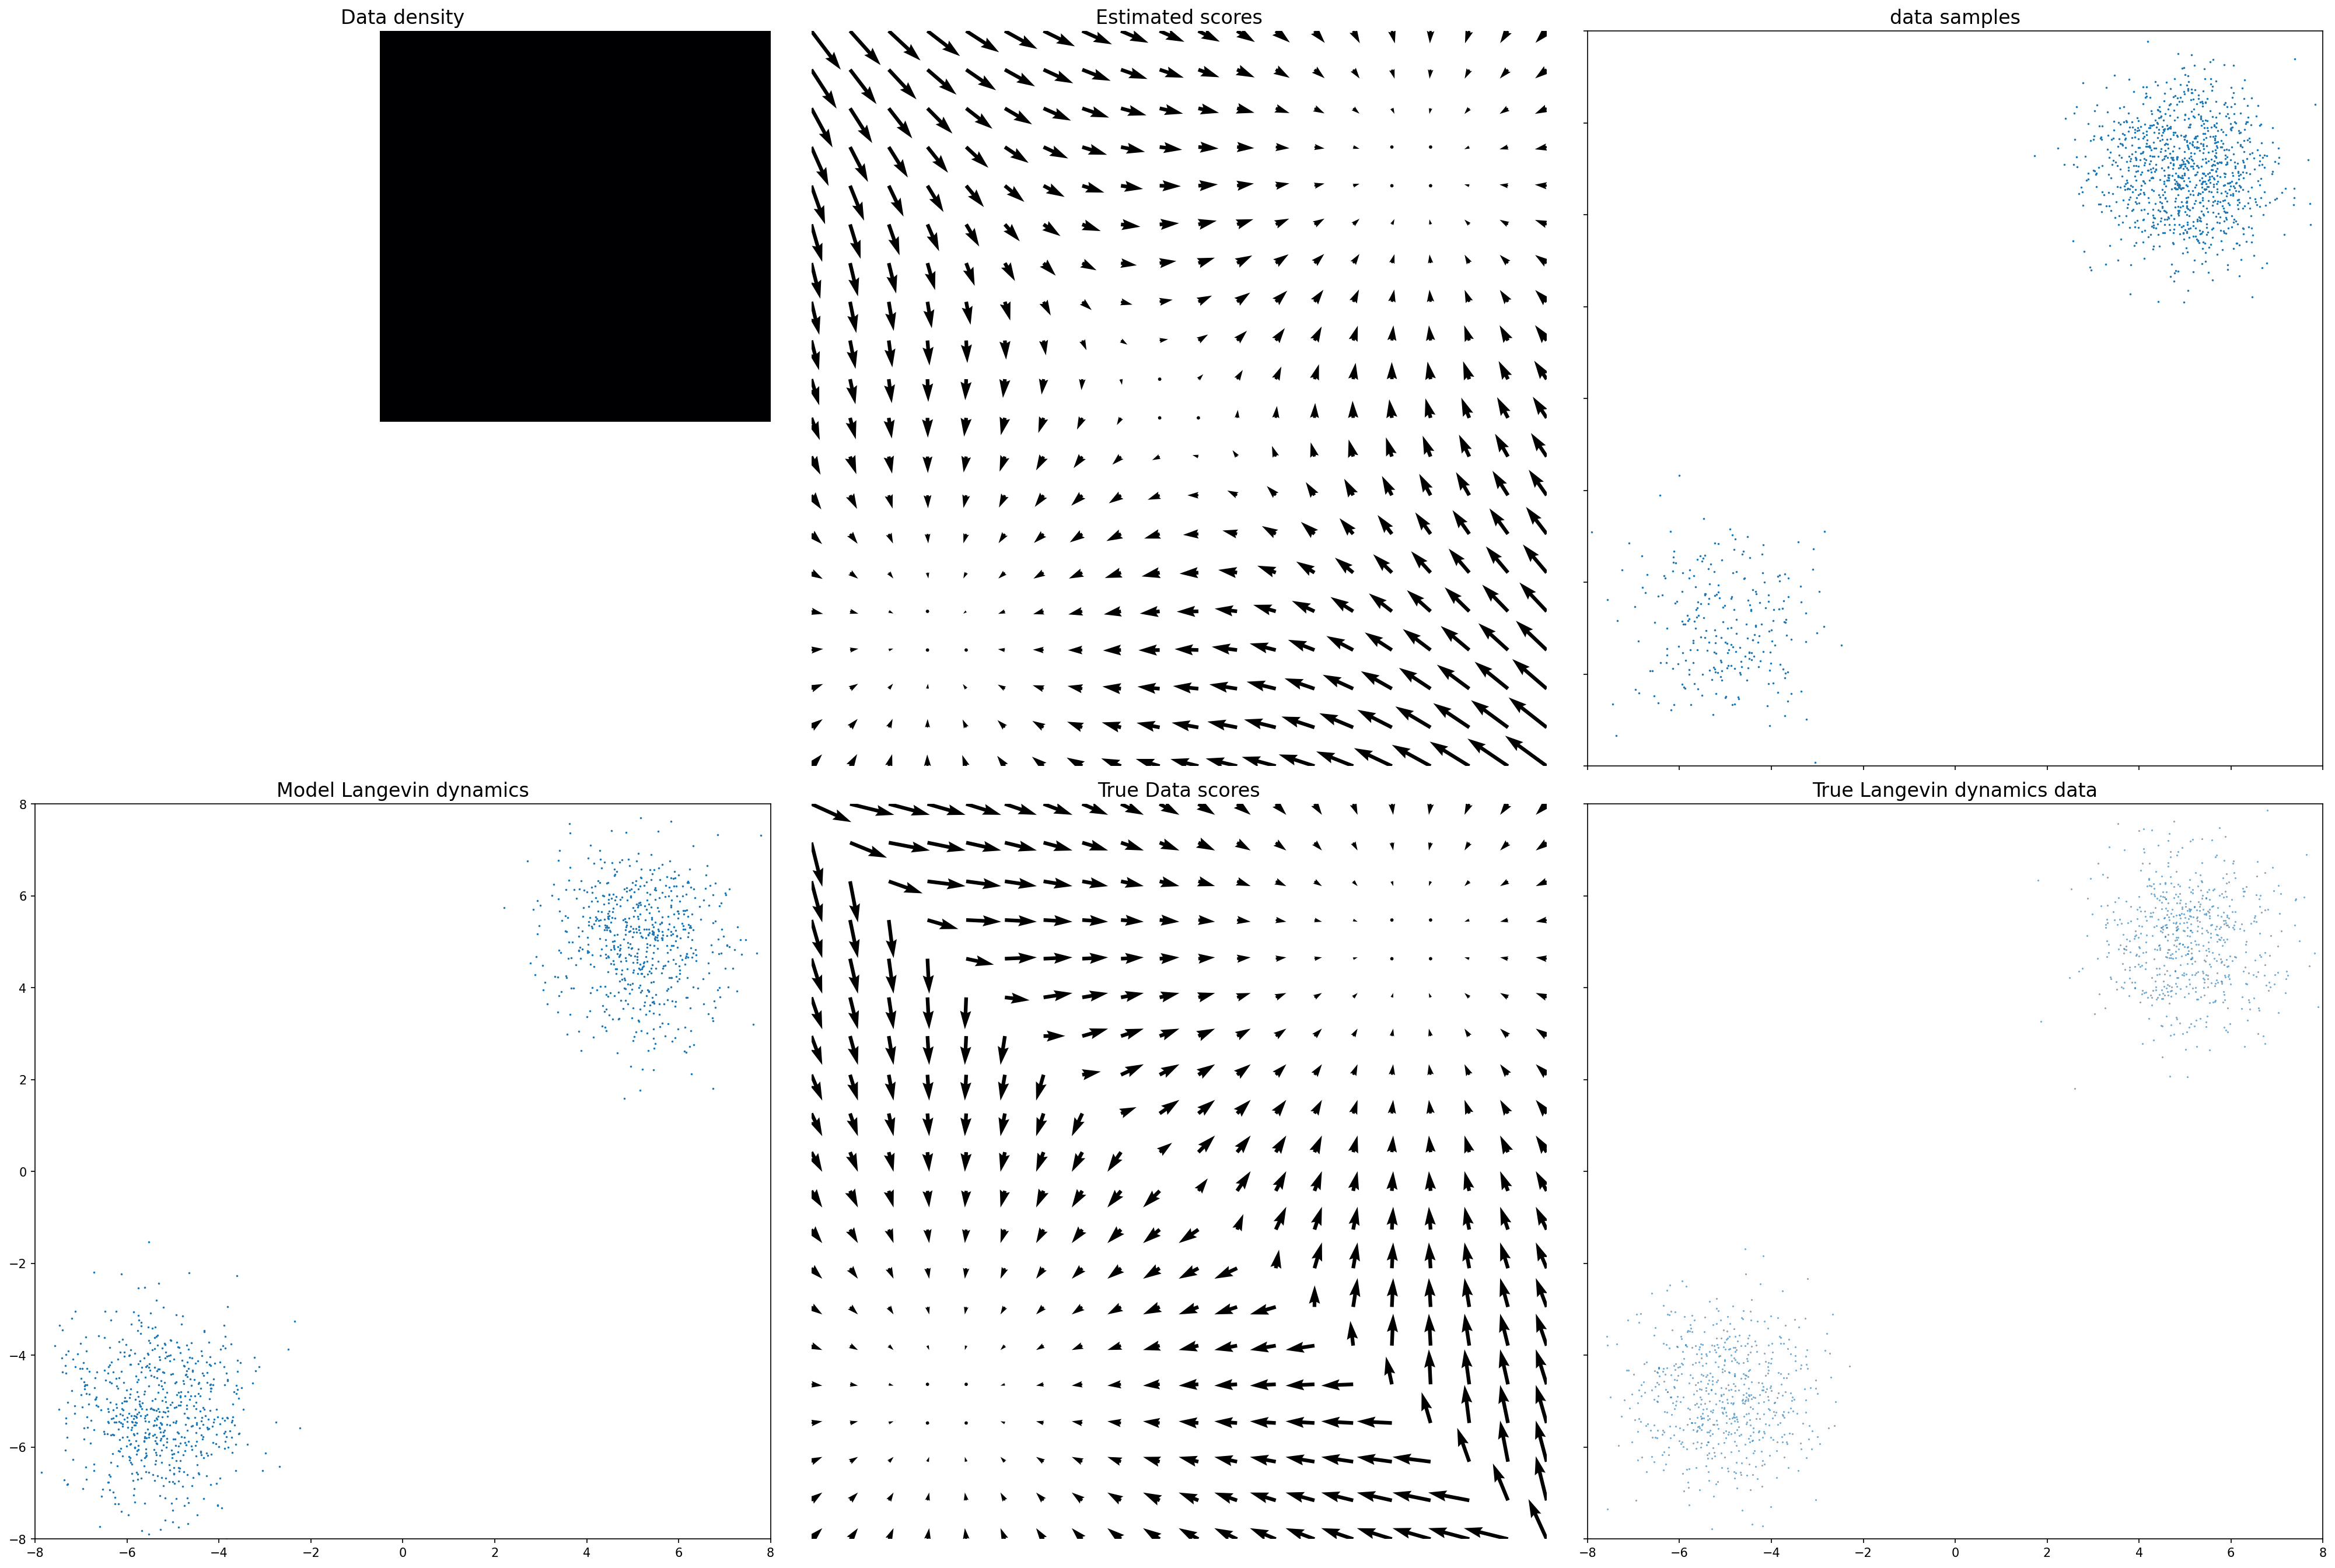

In [ ]:
ncsn.train()

 ![Alt Text]( https://c.tenor.com/Ez_CsXjGMmoAAAAd/mr-bean-mr-beans-holiday.gif)

##  Итоги

1.  Наша задача — нейросетью оценить score-функцию для $p(x)$.
2.  Самый простой способ — это минимизировать дивергенцию Фишера, однако мы не знаем $p(x)$, поэтому задачу регрессии $$|| s_{\theta}(x) - \nabla_{x}\log p(x)||_{2}^{2} \to \min_{\theta}$$ не решить в $\textbf{явном}$ виде.
3.  Можно выполнить score-матчинг, однако он привнесет нестабильную задачу оптимизации.
4.  Если расмотреть оценку не $\nabla_{x}\log p(x)$ , а слегка зашумленного $\nabla_{x}\log p_{\sigma}(x)$ , то можно получить выпуклую стабильную задачу оптмизации. Таким образом, зашумленный score-матчинг работает лучше, но остается проблема того, что векторное поле между модами данных определено плохо.
5. NCSN, за счет рассмотрения разных уровней шума, устраняет недостатки предыдущих методов и демонстрирует лучшее качество генерации.


Полезные ссылки:
- https://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf